# The HFM library - A fast marching solver with adaptive stencils

## Part : Isotropic and anisotropic metrics
## Chapter : Rander metrics

In this notebook, we demonstrate anisotropic fast marching with Rander metrics, in two dimensions. 

Rander metrics are a generalization of Riemannian metrics, featuring an additional linear term. 
They are also a special case of non-symmetric Finslerian metrics.
A Rander metric measures vectors according to the formula:
$$
    F_x(v) := \|v\|_{M(x)} + <\omega(x), v>
$$
where $M$ is a field of symmetric positive definite tensors, and $\omega$ is a vector field.
Applications of Rander metrics include:
* *Zermelo's navigation problem*: find the shortest path for a boat subject to a drift due to ocean current.
* *Chan-Vese segmentation model*: find a sub-domain in an image minimizing an energy comprised of a region term and a boundary term.

The HFM software computes the distance associated to a given Rander metric, and the corresponding minimal paths, by solving a variant of the eikonal PDE. Namely for all $x$ within a domain $\Omega$
$$
    \|\nabla u(x)\|_{D(x)} + <\eta(x),\nabla u(x)> = 1,
%    \|\nabla u(x) - \omega(x)\|_{M(x)^{-1}} = 1.
$$
where $(D,\eta)$ is the dual metric. Some algebraic formulas allow to express the dual metric in terms of $(M,\omega)$, the primal metric, see the first two references below.


**References** The experiments presented in this notebook, or close variants, are presented in the following publications.

* On Zermelo's navigation problem

Mirebeau, J.-M. (2014). Efficient fast marching with Finsler metrics. Numerische Mathematik, 126(3), 515–557. [link](https://hal.archives-ouvertes.fr/hal-00736431)

Mirebeau, J.-M. (2017, April 12). Riemannian fast-marching on cartesian grids using Voronoi's first reduction of quadratic forms. HAL (Preprint). [link](https://hal.archives-ouvertes.fr/hal-01507334)

* On the segmentation problem:

Mirebeau, J.-M., Cohen, L. D., Chen, D., & Mirebeau, J.-M. (2016). Finsler Geodesics Evolution Model for Region based Active Contours. In E. R. H. Richard C Wilson & W. A. P. Smith (Eds.), (pp. 22.1–22.12). Presented at the Proceedings of the British Machine Vision Conference (BMVC), BMVA Press. http://doi.org/10.5244/C.30.22

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Zermelo's navigation problem](#1.-Zermelo's-navigation-problem)
  * [2. The Chan-Vese model](#2.-The-Chan-Vese-model)
    * [2.1 A synthetic instance](#2.1-A-synthetic-instance)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

In [1]:
eikonal_mode = 'cpu'

## 0. Importing the required libraries

In [2]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Rander','FMM'))

In [3]:
from agd import Eikonal
from agd.Plotting import savefig, quiver; #savefig.dirName = 'Figures/Rander'
from agd.Metrics import Rander

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
if eikonal_mode == 'gpu':
    import cupy
    import agd.AutomaticDifferentiation as ad
    np = ad.functional.decorate_module_functions(cupy,ad.cupy_generic.set_output_dtype32) 
    plt = ad.functional.decorate_module_functions(plt,ad.cupy_generic.cupy_get_args)
    quiver = ad.cupy_generic.cupy_get_args(quiver)
    Eikonal.dictIn.default_mode = eikonal_mode

## 1. Zermelo's navigation problem

We compute the travel time and shortest path for a vehicle with unit velocity in all directions, but suject to a  drift. In order words, the vehicle trajectory $\gamma$ obeys at all times 
$$
    \| \gamma'(t) - V(\gamma(t)) \|_{D(\gamma(t))^{-1}} = 1,
$$
where $\eta$ is the given drift, e.g. ocean current. The positive definite tensor field $D$ is chosen here equal to the identity, but could be modified to account for similar problems posed on manifolds.

Zermelo's navigation is locally controllable iff for all $x$ within the domain $\Omega$ one has
$$
    \|V(x)\|_{D(x)^{-1}} < 1.
$$
This condition is a pre-requisite for our eikonal solver to function.

In [6]:
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'exportValues':1,
    'seed':[0.,0.],
})

# Define the domain
n=201
hfmIn.SetRect(sides=[[-0.5,0.5],[-0.5,0.5]],dimx=n)
hfmIn.SetUniformTips((6,6))

In [7]:
X = hfmIn.Grid()
R = np.linalg.norm(X,axis=0)
driftMult = 0.9*np.sin(4*np.pi*X[0])*np.sin(4.*np.pi*X[1])
drift = (driftMult/R) * X

The drift, illustrated in the next figure, increases or decreases the vehicle motion depending on its position and orientation. In particular, we see that close to the image center, the drift field
* *increases* velocity along directions $\pm (1,1)$.
* *decreases* velocity along directions $\pm (1,-1)$. 

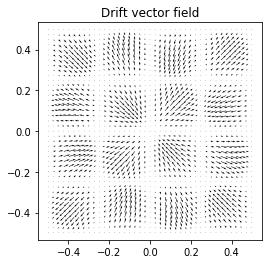

In [8]:
fig = plt.figure(figsize=[4,4]); plt.axis('equal'); 
plt.title('Drift vector field');
quiver(*X,*drift,subsampling=(5,5));
savefig(fig,"DriftVectorField.png")

The Rander metric associated to Zermelo's problem is not completely trivial.
The dual metric of Zermelo's navigation problem is $(D,-V)$, whereas the primal metric has a more complex expression, for which we refer to the papers cited in the introduction. In any case, the relevant formulas are implemented in the Rander class.

In [9]:
hfmIn['metric'] = Rander.from_Zermelo(np.eye(2),drift) # Riemannian metric, and drift

Casting output of function eye from float64 to float32


In [10]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.03599810600280762 seconds, and 40 iterations.
Post-Processing


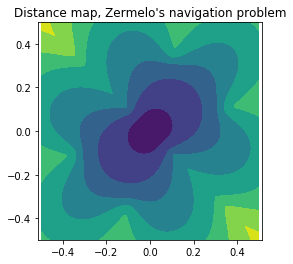

In [11]:
fig = plt.figure(figsize=[4,4]); plt.axis('equal'); 
plt.title('Distance map, Zermelo\'s navigation problem');
plt.contourf(*X,hfmOut['values']);
savefig(fig,"ZermeloDistance.png")

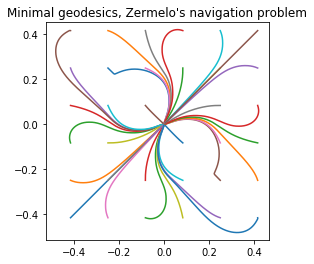

In [12]:
fig = plt.figure(figsize=[4,4]); plt.axis('equal'); 
plt.title('Minimal geodesics, Zermelo\'s navigation problem');
for geo in hfmOut['geodesics']:  plt.plot(*geo) 
savefig(fig,"ZermeloPaths.png")

## 2. The Chan-Vese model

Variational image segmentation methods define image sub-domains by minimizing an energy, comprised of region terms and a boundary terms. The most well known model, the Mumford-Shah model, is also among the most complex and will not be addressed here (unkown number of regions, whose energy contribution is determined by a PDE, cracks, etc ...). 

In the case of binary image segmentation, one is minimizing
$$
    E(U) = F(U) + G(\partial U)
$$
among all sub-domains $U \subset \Omega$, the second region being $\Omega \setminus U$.

In the *Chan-Vese model*, the region term is linear and defined by a function $f$, while the boundary term is a measure of length, possibly defined by a Riemannian metric $M$.
$$
\begin{aligned}
    F(U) &= \int_U f, &
    G(\partial U) &= \mathrm{len}_M(\partial U) 
\end{aligned}
$$
 
Assume that $\partial U$ is parametrized counter-clockwise by a path $\gamma : [0,1] \to \Omega$, and that $f = \mathrm{div} V$ in the neighborhood of $\gamma$ (more on the computation of $V$ below). Then the energy rewrites, using Stokes theorem for the region term,
$$
    E(U) = \int_0^1 \| \gamma'(t) \|_{M(\gamma(t))} + < \gamma'(t), V(t)^\perp> \mathrm{d}t.
$$
In other words, $U$ is optimal if and only iff its boundary is a minimal path w.r.t. the Rander metric of parameters $(M,V^\perp)$. 


**Application examples.** Due to lack of time, only a synthetic problem is presented in this notebook. See the reference in the introduction for application examples.

**An iterative or non-iterative method ?** In ideal conditions, the above characterization allows to extract the optimal sub-domain $U$ in a single run of the fast marching algorithm, with the suitable Rander metric. In practice, an iterative approach is nevertheless required for the following reasons:
* *Placement of the endpoints.* Two endpoints lying exactly on the boundary of the optimal $\partial U$ would be needed to extract $\partial U$ between them. These endpoints are usually not known initially.
* *Positivity of the Rander metric* The above approach is only valid if $(M,V^\perp)$ do define a positive Rander metric, in other words if $\|V(x)^\perp\|_{M(x)^{-1}}$ at each point $x$. Such a vector $V$ is obtained by a convolution, or by solving a poisson equation. In order to meet the smallness requirement, these computations are often limited to a small band around some current guess of the boundary.
* *Non-linear region functional* An iterative approach is required if the region term in the energy is non-linear.

**Note on numerical experiments**
We content ourselves with a purely synthetic instance, and refer to the reference cited in the introduction for application inspired examples.

### 2.1 A synthetic instance

We check the soundness of the approach on a completely analytic instance.
Contour length is measured using the Euclidean metric $M = \mathrm{Id}$.
On the other hand, the region term is defined by the integral of 
$$
\begin{aligned}
    f(x) = 4(\|x\|^2-1) e^{-\|x\|^2}.
\end{aligned}
$$
This function is chosen so that $f=\mathrm{div} V$ with 
$$
\begin{aligned}
    V(x) = - 2 x e^{-\|x\|^2}.
\end{aligned}
$$

In view of the problem symmetries, the energy is maximized on some disk centered at the origin.
The energy of a disk of radius $r$ is 
$$
R(D_r) = 2 \pi \int_0^r f(r) r \mathrm{d}r + 2 \pi r.
$$
This energy is extremal when $1+r f(r)=0$, which occurs for $r=0.64..$ (minimum), and $r=0.30..$ (local maximum).

Casting output of function linspace from float64 to float32


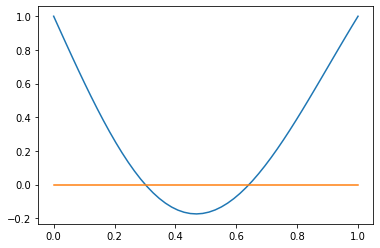

In [13]:
# Roots of 1+r f(r)
r=np.linspace(0,1)
def f(r): 
    return 4*(r**2-1)*np.exp(-r**2)
plt.plot(r,1+r*f(r),
         r,0.*r);

In [14]:
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'exportValues':1,
    
    # Ideal case : the seed and tip are 
    # already on the optimal region boundary
    'seed':[0.64,0.],
    'tip': [-0.64,0.],
})

# Define the domain
n=201
hfmIn.SetRect(sides=[[-1,1],[-1,1]],dimx=n)

X = np.array(hfmIn.Grid())
R = np.linalg.norm(X,axis=0)
v = -2*X*np.exp(-R**2)

hfmIn['metric'] = Rander(np.eye(2),[v[1],-v[0]])

Casting output of function eye from float64 to float32


In [15]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.042501211166381836 seconds, and 73 iterations.
Post-Processing


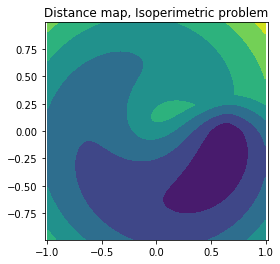

In [16]:
plt.figure(figsize=[4,4]); plt.title('Distance map, Isoperimetric problem'); plt.axis('equal'); 
plt.contourf(*X,hfmOut['values']);

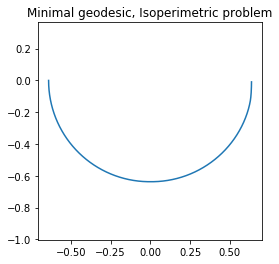

In [17]:
# As expected, the extracted boundary is an arc of circle.
fig = plt.figure(figsize=[4,4]); plt.title('Minimal geodesic, Isoperimetric problem'); plt.axis('equal'); 
plt.plot(*hfmOut['geodesic']);

**Extracting the second half of the boundary**

By exchanging the roles of the seeds and tips, we extract the second half of the boundary.

In [18]:
hfmIn['seed'],hfmIn['tip'] = hfmIn['tip'],hfmIn['seed'] 

In [19]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.03200101852416992 seconds, and 73 iterations.
Post-Processing


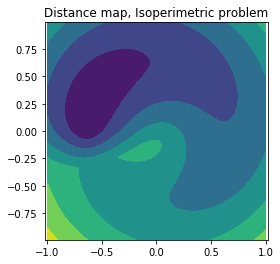

In [20]:
plt.figure(figsize=[4,4]); plt.title('Distance map, Isoperimetric problem'); plt.axis('equal'); 
plt.contourf(*X,hfmOut['values']);

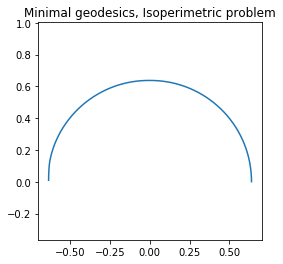

In [21]:
# As expected, the extracted boundary is an arc of circle.
fig = plt.figure(figsize=[4,4]); plt.title('Minimal geodesics, Isoperimetric problem'); plt.axis('equal'); 
plt.plot(*hfmOut['geodesic']);

In [32]:
#Mathematica code to find the roots
#F[r_] := 4 (r^2 - 1) Exp[-r^2]; 
#FindRoot[1 + r F[r], {r, #}] & /@ {0.3, 0.6}
#{{r -> 0.300963}, {r -> 0.64182}}

<!---### Segmentation example

This section is TODO. 
--->